In [9]:
import numpy as np
import pandas as pd
import os

from tvb.simulator.lab import *
import sys
import scipy.io
import tvbsim

np.random.seed(123456789)

import colorednoise as cn

# plotting fxns
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# set all directories
root_dir = os.path.join('/Users/adam2392/Documents/pydata/')

patient='id008_gc'
# patient ='id013_pg'
# patient = 'id001_ac'

expname = 'exp006'
samplerate = 1000

metadatadir = os.path.join(root_dir, "metadata", patient)
outputdatadir = os.path.join('/Users/adam2392/Documents/pydata/tvbforwardsim/', expname)
if not os.path.exists(outputdatadir):
    os.makedirs(outputdatadir)

tvbsim.util.renamefiles(patient, metadatadir)

# get the important files
getfilepath = lambda filename: os.path.join(metadatadir, filename)
seegfile = getfilepath('seeg.txt')
gainfile = getfilepath('gain_inv-square.txt')
# surffile = getfilepath

Already renamed seeg.xyz possibly!


In [3]:
dist = -1
filename = os.path.join(outputdatadir, 
        patient+'_dist' + str(dist) + 'testall_longer.npz')
npfile = open(filename, 'r')

data = np.load(npfile)
epits = data['epits']
seegts = data['seegts']
times = data['times']
zts = data['zts']
metadata = data['metadata'].item()

print(metadata.keys())
ezind = metadata['ezindices']
pzind = metadata['pzindices']
seizonsets = metadata['onsettimes']
seizoffsets = metadata['offsettimes']
region_labels = metadata['regions']

# get the onsettimes and offsettimes for ez/pz indices
allindices = np.append(ezind, pzind, axis=0).astype(int)
postprocessor = tvbsim.postprocess.PostProcessor(samplerate=samplerate, allszindices=allindices)
settimes = postprocessor.getonsetsoffsets(zts, allindices, lookahead=100, delta=0.2)# get the actual seizure times and offsets
seizonsets, seizoffsets = postprocessor.getseiztimes(settimes, epsilon=0)

['patient', 'pz', 'epiparams', 'seeg_xyz', 'onsettimes', 'x0ez', 'regions_centers', 'regions', 'offsettimes', 'x0pz', 'ez', 'pzindices', 'x0norm', 'ezindices', 'chanlabels']


In [7]:
dt = 0.05

noiseobject = tvbsim.postprocess.noise.Noise()
noiseobject.configure_coloured(dt=dt, shape=)

TypeError: configure_coloured() takes exactly 3 arguments (1 given)

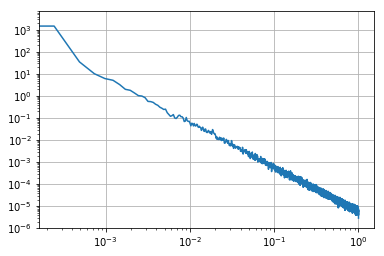

In [11]:
beta = 2 # the exponent
samples = 2**18 # number of samples to generate
y = cn.powerlaw_psd_gaussian(beta, samples)

# optionally plot the Power Spectral Density with Matplotlib
from matplotlib import mlab
#from matplotlib import pylab as plt
s, f = mlab.psd(y, NFFT=2**13)
plt.loglog(f,s)
plt.grid(True)
plt.show()